# The code

In [1]:
import numpy as np
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from warnings import warn
from uncertainties import ufloat
import corner
import multiprocessing
from tqdm import tqdm
from joblib import delayed
import joblib
from tqdm.auto import tqdm
from scipy import stats

class ProgressParallel(joblib.Parallel):
    def __call__(self, *args, **kwargs):
        with tqdm() as self._pbar:
            return joblib.Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()

def is_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

class FourierFitter():
    def __init__(self,t, y, error=None):
        '''
        t : array-like
            Time values of the light curve.
        y : array-like
            Flux/mag values of the light curve.
        error : array-like, optional
            Flux/mag errors values of the light curve. If not given, Fourier parameter
            errors will be less reliable. In this case use `error_estimation`.
        '''
        self.t = t
        self.y = y
        self.error = error
        
    def func(self, time, amp, best_freq, phase, kind='sin'):
        # sin or cos funtion to be fitted
        if kind=='sin':
            y = amp*np.sin(2*np.pi*best_freq*time + phase )
        elif kind=='cos':
            y = amp*np.cos(2*np.pi*best_freq*time + phase )
        else:
            raise TypeError('%s format does not exist. Select \'sin\' or \'cos\'.' % str(kind))
        return y

    def fit_all(self, *arg):
        # fit all periodic components at the same time
        time = arg[0]
        best_freq = arg[1]
        nparams = (len(arg)-3)//2
        amps = arg[2:2+nparams]
        phases = arg[2+nparams:-2]
        const = arg[-2]
        kind = arg[-1]
        y = 0
        for i in range(len(amps)):
            y += self.func(time, amps[i], (i+1)*best_freq, phases[i],kind=kind)
        y += const
        return y

    def estimate_errors(self,seed):
        np.random.seed(seed)
        
        if self.error_estimation == 'bootstrap':
            tmp_lc = self.lc[np.random.choice( self.lc.shape[0], int(len(self.lc)*self.sample_size), replace=False), :]
        elif self.error_estimation == 'montecarlo':
            tmp_lc = self.lc.copy()
            
            if self.error is None:
                tmp_lc[:,1] += np.random.normal(0,self.yerror,tmp_lc.shape[0])
            else:
                tmp_lc[:,1] += np.random.normal(0,self.error,tmp_lc.shape[0])
            
        # Subtract mean from time points to decouple frequencies from phases
        tmp_lc[:,0] -= tmp_lc[:,0].mean()
        
        lbound = [0]*(1+len(self.amps)) + [-np.inf]*len(self.phases) + [-np.inf]
        ubound = [2*self.freqs[0]] + [np.ptp(self.y)]*len(self.amps) + [np.inf]*len(self.phases) + [np.inf]
        bounds = (lbound,ubound)
        if self.error is None:
            tmp_pfit, _ = curve_fit(lambda *args: self.fit_all(*args, self.kind), tmp_lc[:,0], tmp_lc[:,1], p0=(self.freqs[0], *self.amps, *self.phases, np.mean(tmp_lc[:,1])), 
                                    bounds=bounds, maxfev=5000)
        else:
            tmp_pfit, _ = curve_fit(lambda *args: self.fit_all(*args, self.kind), tmp_lc[:,0], tmp_lc[:,1], p0=(self.freqs[0], *self.amps, *self.phases, np.mean(tmp_lc[:,1])) , 
                              sigma=tmp_lc[:,2], absolute_sigma=self.absolute_sigma, bounds=bounds, maxfev=5000)
        
        tmp_pfit[1+len(self.amps):-1] = tmp_pfit[1+len(self.amps):-1]%(2*np.pi)
        
        return tmp_pfit

    def fit_freqs(self,
                  absolute_sigma=True,
                  nfreq = 3,plotting = False,
                  minimum_frequency=None, maximum_frequency=None,
                  nyquist_factor=1,samples_per_peak=100,
                  kind='sin',
                  error_estimation='analytic',ntry=100,
                  sample_size=0.999,
                  parallel=False, ncores=-1,
                  refit=False):
        """
        ``fit_freqs`` performs Fourier pre-whitening and harmonic fitting.
        Parameters
        ----------
        absolute_sigma : bool, default: True
            If `True`, error is used in an absolute sense and the estimated parameter covariance
            reflects these absolute values.
        nfreq : int, default: 3
            The number of harmonics to be fitted. Pass a very large number to fit all harmonics.
        plotting: bool, default: False
            If `True`, fitting steps will be displayed.
        minimum_frequency : float, optional
            If specified, then use this minimum frequency rather than one chosen based on the size
            of the baseline.
        maximum_frequency : float, optional
            If specified, then use this maximum frequency rather than one chosen based on the average
            nyquist frequency.
        nyquist_factor : float, default: 1
            The multiple of the average nyquist frequency used to choose the maximum frequency
            if ``maximum_frequency`` is not provided.
        samples_per_peak:  float, default: 100
            The approximate number of desired samples across the typical frequency peak.
        kind: str, 'sin' or 'cos'
            Harmonic function to be fitted.
        error_estimation: `analytic`, `bootstrap` or `montecarlo`, default: `analytic`
            If `bootstrap` or `montecarlo` is choosen, boostrap or monte carlo method will be used to estimate parameter uncertainties.
            Otherwise given uncertainties are calculated analytically.
        ntry: int, default: 100
            Number of resamplings for error estimation.
        sample_size: float, default: 0.999
            The ratio of data points to be used for bootstrap error estimation in each step.
            Applies only if `error_estimation` is set to `bootstrap`.
        parallel: bool, default : False
            If `True`, sampling for error estimation is performed parallel to speed up the process.
        ncores: int, default: -1
            Number of CPU cores to be used for parallel error estimation. If `-1`, then all available
            cores will be used.
        Returns
        -------
        pfit : array-like
            Array of fitted parameters. The main frequency, amplitudes and phases of the harmonics,
            and the zero point.
        perr : array-like
            Estimated error of the parameters.
        """
        self.sample_size = sample_size
        self.kind = kind
        self.absolute_sigma = absolute_sigma
        self.error_estimation = error_estimation

        if minimum_frequency is not None and maximum_frequency is not None:
            if minimum_frequency > maximum_frequency:
                raise ValueError('Minimum frequency is larger than maximum frequency.')

        if nfreq<1:
            raise ValueError('Number of frequencies must be >1.')
            
        if maximum_frequency is None and nyquist_factor * (0.5/np.median( np.diff(self.t) )) < 2.:
            # Nyquist is low
            warn('Nyquist frequency is low!\nYou might want to set maximum frequency instead.')
            
        if error_estimation not in ['analytic','bootstrap','montecarlo']:
            raise TypeError('%s method is not supported! Please choose \'analytic\', \'bootstrap\' or \'montecarlo\'.' % str(error_estimation))

        # fit periodic funtions and do prewhitening
        yres = self.y.copy()

        self.freqs = []
        self.amps = []
        self.phases = []
        self.zeropoints = []
        self.freqserr = []
        self.ampserr = []
        self.phaseserr = []
        self.zeropointerr = []

        for i in range(nfreq):
            if i == 0:
                ls = LombScargle(self.t, yres, nterms=1)
                freq, power = ls.autopower(normalization='psd',
                                           minimum_frequency=minimum_frequency,
                                           maximum_frequency=maximum_frequency,
                                           samples_per_peak=samples_per_peak,
                                           nyquist_factor=nyquist_factor)

                # get first spectrum and fit first periodic component
                try:
                    best_freq = freq[power.argmax()]

                    pfit1, pcov1 = curve_fit(lambda time, amp, phase, const: self.func(time, amp, best_freq, phase ,kind=kind) + const, self.t, yres,
                                          p0=(np.ptp(yres)/4,2.,np.mean(yres)), bounds=([0,0,-np.inf], [np.ptp(yres), 2*np.pi, np.inf]) , 
                                          sigma=self.error, absolute_sigma=absolute_sigma, maxfev=5000)
                    pfit2, pcov2 = curve_fit(lambda time, amp, phase, const: self.func(time, amp, best_freq, phase ,kind=kind) + const, self.t, yres,
                                          p0=(np.ptp(yres)/4,5.,np.mean(yres)), bounds=([0,0,-np.inf], [np.ptp(yres), 2*np.pi, np.inf]) , 
                                          sigma=self.error, absolute_sigma=absolute_sigma, maxfev=5000)

                    chi2_1 = np.sum( (yres-pfit1[-1] - self.func(self.t, pfit1[0], best_freq, pfit1[1] ,kind=kind))**2 )
                    chi2_2 = np.sum( (yres-pfit2[-1] - self.func(self.t, pfit2[0], best_freq, pfit2[1] ,kind=kind))**2 )

                    if chi2_1 < chi2_2:
                        pfit = pfit1
                    else:
                        pfit = pfit2

                    pfit, pcov = curve_fit(lambda time, amp, freq, phase, const: self.func(time, amp, freq, phase, kind=kind) + const, self.t, yres,
                                          p0=(pfit[0],best_freq,pfit[1],np.mean(yres)), bounds=([0,0,0,-np.inf], [np.ptp(yres), 2*best_freq, 2*np.pi, np.inf]) , 
                                          sigma=self.error, absolute_sigma=absolute_sigma, maxfev=5000)

                    best_freq = pfit[1]

                except (RuntimeError,ValueError):
                    self.pfit = self.perr = [np.nan]*(nfreq*2+1)
                    return self.pfit, self.perr

            else:
                # --- Check if frequency is greater than maximum_frequency ---
                if maximum_frequency is not None and (i+1)*best_freq > maximum_frequency:
                    # freq > maximum_frequency
                    warn('Frequency is larger than maximum frequency!\nIncrease maximum frequency to include more peaks!\nSkipping...')
                    break
                elif maximum_frequency is None and (i+1)*best_freq > nyquist_factor * (0.5/np.median( np.diff(self.t) )):
                    # freq > nyquist_factor * Nyquist
                    warn('Frequency is larger than nyquist_factor (%d) x Nyquist frequency!\nSet maximum frequency to avoid problems!\nSkipping...' % int(nyquist_factor))
                    break
                    
                # --- Check if max power is still above the noise level ---
                ls = LombScargle(self.t, yres, nterms=1)
                minf = (i+1)*best_freq-0.5
                if minf<0 : minf = 0
                    
                with np.errstate(divide='ignore',invalid='ignore'):
                    freq, power = ls.autopower(normalization='psd',
                                               minimum_frequency=minf,
                                               maximum_frequency=(i+1)*best_freq+0.5,
                                               samples_per_peak=samples_per_peak)
                
                goodpts = np.isfinite(power)
                freq = freq[goodpts]
                power = power[goodpts]
                power[power<0] = 0
                        
                df = 1/np.ptp(self.t)
                umpeak = (freq > (i+1)*best_freq - df) & (freq < (i+1)*best_freq + df)
                if np.nanmax(np.sqrt(power[umpeak])) <= np.nanmean(np.sqrt(power)) + 3*np.nanstd(np.sqrt(power)):
                    # peak height < mean + 3 std
                    break
                    
                # --- Check if best period is longer than 2x data duration ---
                if np.allclose(freq[np.argmax(power)] ,0) or 1./freq[np.argmax(power)] > 2*np.ptp(self.t):
                    warn('Period is longer than 2x data duration!\nSet minimum frequency to avoid problems!\nSkipping...') 
                    break
                
                # --- get ith spectrum and fit ith periodic component ---
                pfit1, pcov1 = curve_fit(lambda time, amp, phase, const: self.func(time, amp, (i+1)*best_freq, phase, kind=kind) + const, self.t, yres,
                                          p0=(np.ptp(yres)/4,2.,np.mean(yres)), bounds=([0,0,-np.inf], [np.ptp(yres), 2*np.pi, np.inf]) , 
                                          sigma=self.error, absolute_sigma=absolute_sigma, maxfev=5000)
                pfit2, pcov2 = curve_fit(lambda time, amp, phase, const: self.func(time, amp, (i+1)*best_freq, phase, kind=kind) + const, self.t, yres,
                                          p0=(np.ptp(yres)/4,5.,np.mean(yres)), bounds=([0,0,-np.inf], [np.ptp(yres), 2*np.pi, np.inf]) , 
                                          sigma=self.error, absolute_sigma=absolute_sigma, maxfev=5000)

                chi2_1 = np.sum( (yres-pfit1[-1] - self.func(self.t, pfit1[0], (i+1)*best_freq, pfit1[1], kind=kind ))**2 )
                chi2_2 = np.sum( (yres-pfit2[-1] - self.func(self.t, pfit2[0], (i+1)*best_freq, pfit2[1], kind=kind ))**2 )

                if chi2_1 < chi2_2:
                    pfit = pfit1
                    pcov = pcov1
                else:
                    pfit = pfit2
                    pcov = pcov2

            if plotting:
                # plot phased light curve and fit
                if i==0:
                    per = 1/pfit[1]
                else:
                    per = 1/( (i+1)*best_freq )
                    
                    # Calculate spectrum for plotting
                    ls = LombScargle(self.t, yres, nterms=1)
                    freq, power = ls.autopower(normalization='psd',
                                               minimum_frequency=minimum_frequency,
                                               maximum_frequency=maximum_frequency,
                                               samples_per_peak=samples_per_peak,
                                               nyquist_factor=nyquist_factor)
                        
                plt.figure(figsize=(15,3))
                plt.subplot(121)
                plt.plot(freq, power)
                plt.xlabel('Frequency (c/d)')
                plt.ylabel('LS power')
                plt.grid()
                plt.subplot(122)
                plt.plot(self.t%per/per,yres-pfit[-1],'k.')
                plt.plot(self.t%per/per+1,yres-pfit[-1],'k.')
                if i == 0:
                    plt.plot(self.t%per/per,self.func(self.t,pfit[0],pfit[1],pfit[2], kind=kind),'C1.',ms=1)
                    plt.plot(self.t%per/per+1,self.func(self.t,pfit[0],pfit[1],pfit[2], kind=kind),'C1.',ms=1)
                else:
                    plt.plot(self.t%per/per,self.func(self.t,pfit[0],(i+1)*best_freq,pfit[1], kind=kind),'C1.',ms=1)
                    plt.plot(self.t%per/per+1,self.func(self.t,pfit[0],(i+1)*best_freq,pfit[1], kind=kind),'C1.',ms=1)
                plt.xlabel('Phase')
                plt.ylabel('Brightness')
                plt.show()

            if i==0:
                # start to collect results
                self.freqs.append( pfit[1] )
                self.amps.append( pfit[0] )
                self.phases.append( pfit[2] )
                self.zeropoints.append( pfit[3] )

                pcov = np.sqrt(np.diag(pcov))
                self.freqserr.append( pcov[1] )
                self.ampserr.append( pcov[0] )
                self.phaseserr.append( pcov[2] )
                self.zeropointerr.append( pcov[3] )

                yres -= self.func(self.t,pfit[0],pfit[1],pfit[2], kind=kind) + pfit[3]
            else:
                # collect ith results
                self.freqs.append( (i+1)*best_freq )
                self.amps.append( pfit[0] )
                self.phases.append( pfit[1] )
                self.zeropoints.append( pfit[2] )

                pcov = np.sqrt(np.diag(pcov))
                self.freqserr.append( self.freqserr[0] )
                self.ampserr.append( pcov[0] )
                self.phaseserr.append( pcov[1] )
                self.zeropointerr.append( pcov[2] )

                yres -= self.func(self.t,pfit[0],(i+1)*best_freq,pfit[1], kind=kind) + pfit[2]

        try:
            # fit all periodic components at the same time
            lbound = [0]*(1+len(self.amps)) + [-np.inf]*len(self.phases) + [-np.inf]
            ubound = [2*best_freq] + [np.ptp(self.y)]*len(self.amps) + [np.inf]*len(self.phases) + [np.inf]
            bounds = (lbound,ubound)
            pfit, pcov = curve_fit(lambda *args: self.fit_all(*args, kind), self.t, self.y, p0=(self.freqs[0], *self.amps, *self.phases, np.mean(self.y)) , 
                                    bounds=bounds, sigma=self.error, absolute_sigma=absolute_sigma, maxfev=5000)

            # convert all phases into the 0-2pi range
            pfit[1+len(self.amps):-1] = pfit[1+len(self.amps):-1]%(2*np.pi)
            
            '''
            # if any of the errors is inf, shift light curve by period/2 and get new errors
            if not error_estimation and np.any(np.isinf(pcov)):
                warn('One of the errors is inf! Shifting light curve by half period to calculate errors...')
                lbound = [0]*(1+len(self.amps)) + [-np.inf]*len(self.phases) + [-np.inf]
                ubound = [2*best_freq] + [np.ptp(self.y)]*len(self.amps) + [np.inf]*len(self.phases) + [np.inf]
                bounds = (lbound,ubound)
                _, pcov = curve_fit(lambda *args: self.fit_all(*args, kind), self.t + 0.5/pfit[0], self.y, p0=(self.freqs[0], *self.amps, *[(pha+np.pi)%(2*np.pi) for pha in self.phases], np.mean(self.y)) , 
                                    bounds=bounds, sigma=self.error, absolute_sigma=absolute_sigma, maxfev=5000)
            '''
            
            if error_estimation is 'analytic':
                self.pfit = pfit
                self.perr = self.get_analytic_uncertainties() + [ np.sqrt(np.diag(pcov))[-1] ]  
            
                return self.pfit, self.perr
            
            elif error_estimation is not 'analytic' and refit is False:
                # use bootstrap or MC to get realistic errors (bootstrap = get subsample and redo fit n times)
                if self.error is None: self.lc = np.c_[self.t, self.y]
                else:                  self.lc = np.c_[self.t, self.y, self.error]
                    
                self.pfit = pfit
                if self.error is None:
                    #self.yerror = 0.5*np.std(self.get_residual()[1])
                    self.yerror = stats.median_abs_deviation(self.get_residual()[1])

                if   error_estimation == 'bootstrap':  print('Bootstrapping...',flush=True)
                elif error_estimation == 'montecarlo': print('Performing monte carlo...',flush=True)
                    
                error_estimation_fit = np.empty( (ntry,len(pfit)) )
                seeds = np.random.randint(1e09,size=ntry)
                if parallel:
                    # do error estimation fit parallal
                    available_ncores = multiprocessing.cpu_count()
                    if ncores <= -1:
                        ncores = available_ncores
                    elif available_ncores<ncores:
                        ncores = available_ncores

                    error_estimation_fit = ProgressParallel(n_jobs=ncores)(delayed(self.estimate_errors)(par) for par in seeds)
                    error_estimation_fit = np.asarray(error_estimation_fit)
                    
                else:
                    for i,seed in tqdm(enumerate(seeds),total=ntry):
                        error_estimation_fit[i,:] = self.estimate_errors(seed)

                #meanval = np.nanmean(error_estimation_fit,axis=0)
                #perr = np.nanstd(error_estimation_fit,axis=0)
                bspercentiles = np.percentile(error_estimation_fit,[16, 50, 84],axis=0)
                perr = np.min(np.c_[bspercentiles[2]-bspercentiles[1],bspercentiles[1]-bspercentiles[0]],axis=1)
                
                if plotting:
                    labels = [r'Freq'] + [r'A$_'+str(i+1)+'$' for i in range(len(self.amps))] + \
                             [r'$\Phi_'+str(i+1)+'$' for i in range(len(self.phases))] + [r'Zero point']

                    if np.sum( is_outlier(error_estimation_fit) ) < 0.05*error_estimation_fit.shape[0]:
                        # Drop outliers if their number is low to not to change the distributions
                        _ = corner.corner(error_estimation_fit[~is_outlier(error_estimation_fit)],
                                           labels=labels,
                                           quantiles=[0.16, 0.5, 0.84],
                                           show_titles=True, title_kwargs={"fontsize": 12})
                    else:
                        _ = corner.corner(error_estimation_fit,
                                           labels=labels,
                                           quantiles=[0.16, 0.5, 0.84],
                                           show_titles=True, title_kwargs={"fontsize": 12})

                if np.any(perr == 0.0):
                    # if any of the errors is 0, shift light curve by period/2 and get new errors
                    warn('One of the errors is too small! Shifting light curve by half period to calculate errors...')
                    
                    torig = self.t.copy()
                    yorig = self.y.copy()

                    _,newperr = self.fit_freqs(self.t + 0.5/pfit[0], self.y, nfreq = nfreq,plotting = False,
                                  kind=kind,
                                  minimum_frequency=minimum_frequency,maximum_frequency=maximum_frequency,
                                  nyquist_factor=nyquist_factor,samples_per_peak=samples_per_peak,
                                  error_estimation=error_estimation,ntry=ntry,sample_size=self.sample_size,
                                  refit=True)

                    try:
                        um = np.where( perr == 0.0 )[0]
                        perr[um] = np.copy(newperr[um])
                    except IndexError:
                        pass
                    self.t = torig
                    self.y = yorig
                    self.pfit = pfit
                    self.perr = perr
                    return self.pfit, self.perr

                self.pfit = pfit
                self.perr = perr
                return self.pfit, self.perr

            elif error_estimation is not 'analytic' and refit:
                # get new errors for shifted light curve
                if self.error is None: self.lc = np.c_[self.t, self.y]
                else:                  self.lc = np.c_[self.t, self.y, self.error]

                error_estimation_fit = np.empty( (ntry,len(pfit)) )
                seeds = np.random.randint(1e09,size=ntry)
                if parallel:
                    # do error_estimation fit parallal
                    available_ncores = multiprocessing.cpu_count()
                    if ncores <= -1:
                        ncores = available_ncores
                    elif available_ncores<ncores:
                        ncores = available_ncores

                    error_estimation_fit = ProgressParallel(n_jobs=ncores)(delayed(self.estimate_errors)(par) for par in seeds)
                    error_estimation_fit = np.asarray(error_estimation_fit)
                                
                else:
                    for i,seed in tqdm(enumerate(seeds),total=ntry):
                        error_estimation_fit[i,:] = self.estimate_errors(seed)

                #meanval = np.nanmean(error_estimation_fit,axis=0)
                #newperr = np.nanstd(error_estimation_fit,axis=0)
                bspercentiles = np.percentile(error_estimation_fit,[16, 50, 84],axis=0)
                newperr = np.min(np.c_[bspercentiles[2]-bspercentiles[1],bspercentiles[1]-bspercentiles[0]],axis=1)

                self.pfit = pfit
                self.perr = newperr
                return self.pfit, self.perr

        except RuntimeError:
            # if fit all components at once fails return previous results, and errors from covariance matrix
            if error_estimation:
                warn('%s method failed! Returning errors from pre-whitening steps.' % str(error_estimation))

            warn('Something went wrong! Returning errors from pre-whitening steps.')
            
            self.pfit = np.array([self.freqs[0], *self.amps, *self.phases, self.zeropoints[0] ])
            self.perr = np.array([self.freqserr[0], *self.ampserr, *self.phaseserr, self.zeropointerr[0] ])
            return self.pfit, self.perr

    def get_fourier_parameters(self):
        """
        Calculates Fourier parameters from given amplitudes and phases.
  
        Returns
        -------
        freq : number with uncertainty
            Main frequency and its estimated error.
        period : 
            Main period and its estimated error.
        P21 : number with uncertainty
            Phi21 and its estimated error.
        P31 : number with uncertainty
            Phi31 and its estimated error.
        R21 : number with uncertainty
            R21 and its estimated error.
        R31 : number with uncertainty
            R31 and its estimated error.
        """
        if ~np.all(np.isnan(self.pfit)) and len(self.pfit)==6:
            nfreq = int(  (len(self.pfit)-1)/2  )
            
            freq = ufloat(self.pfit[0],self.perr[0])
            period = 1/freq
            R21 = ufloat(self.pfit[2],self.perr[2]) / ufloat(self.pfit[1],self.perr[1])
            R31 = ufloat(np.nan,np.nan)
            P21 = ( ufloat(self.pfit[nfreq+2],self.perr[nfreq+2] )- 2* ufloat(self.pfit[nfreq+1],self.perr[nfreq+1]) )%(2*np.pi)
            P31 = ufloat(np.nan,np.nan)
            
        elif np.all(np.isnan(self.pfit)) or len(self.pfit)<=6:
            warn('Not enough components to get Fourier parameters!') 
            #raise ValueError('Not enough components to get Fourier parameters!') 
            
            freq = ufloat(np.nan,np.nan)
            period = ufloat(np.nan,np.nan)
            R21 = ufloat(np.nan,np.nan)
            R31 = ufloat(np.nan,np.nan)
            P21 = ufloat(np.nan,np.nan)
            P31 = ufloat(np.nan,np.nan)
        
        else:
            nfreq = int(  (len(self.pfit)-1)/2  )

            freq = ufloat(self.pfit[0],self.perr[0])
            period = 1/freq
            R21 = ufloat(self.pfit[2],self.perr[2]) / ufloat(self.pfit[1],self.perr[1])
            R31 = ufloat(self.pfit[3],self.perr[3]) / ufloat(self.pfit[1],self.perr[1])
            P21 = ( ufloat(self.pfit[nfreq+2],self.perr[nfreq+2] )- 2* ufloat(self.pfit[nfreq+1],self.perr[nfreq+1]) )%(2*np.pi)
            P31 = ( ufloat(self.pfit[nfreq+3],self.perr[nfreq+3] )- 3* ufloat(self.pfit[nfreq+1],self.perr[nfreq+1]) )%(2*np.pi)

        return freq,period,P21,P31,R21,R31
    
    def get_residual(self):
        """
        Calculates the residual light curve after Fourier fitting.
  
        Returns
        -------
        t : array
            Time stamps.
        y : array
            Residual flux/amp.
        yerr : array, optional
            If input errors were given, then error of residual flux/amp.
        """
        if self.error is None:
            return self.t, self.y - self.fit_all(self.t, *self.pfit, self.kind)
        else:
            return self.t, self.y - self.fit_all(self.t, *self.pfit, self.kind), self.error
        
    def _analytic_uncertainties(self,time,residual,amp):
        N = len(time)
        T = np.ptp(time)
        sigma_m = np.std(residual)

        sigma_f = np.sqrt(6/N) * 1/(np.pi*T) * sigma_m/amp
        sigma_a = np.sqrt(2/N) * sigma_m
        sigma_phi = 1/(2*np.pi) * np.sqrt(2/N) * sigma_m/amp

        return sigma_f,sigma_a,sigma_phi
    
    def get_analytic_uncertainties(self):
        """
        Calculates analytically derived uncertenties based on Breger et al. 1999.
  
        Returns
        -------
        perr : array-like
            Estimated error of the parameters.
        """
        resy = self.get_residual()[1]
        sigf = self._analytic_uncertainties(self.t,resy,self.pfit[1])[0]
        
        sigA = []
        sigPhi = []
        ncomponents = int((len(self.pfit)-1)/2)
        for i in range(1, ncomponents + 1 ):
            sigmas = self._analytic_uncertainties(self.t,resy,self.pfit[i])
            sigA.append( sigmas[1] )
            sigPhi.append( sigmas[2] )
            
        return [sigf] + sigA + sigPhi

# Important notes

- The Fourier series fit can be done via two ways. Fitting $sine$ or $cosine$ functions:

 $$ \sum_i A_i sin( 2\pi f_i t + \phi_i ) + constant $$,

 $$ \sum_i A_i cos( 2\pi f_i t + \phi_i ) + constant $$

 where $A_i$ is the semi-amplitude, $f_i$ is the frequency and $\phi_i$ is the phase of the given component. The _constant_ is the zero point of the light curve.

 This is __optional in the code__. Use the keyword `kind='sin'` or `kind='cos'` to select one. The default is _sine_.

- After the fitting of ___at least___ 3 frequencies the Fourier parameters are calculated as

 $$ R_{21} = \frac{A_2}{A_1} $$ ,
 $$ R_{31} = \frac{A_3}{A_1} $$ ,
 $$ \phi_{21} = \phi_2 - 2 \phi_1 $$ ,
 $$ \phi_{31} = \phi_3 - 3 \phi_1 $$

 which values __depend on__ the ___chosen function (sine or cosine)___, the ___physical units (flux or mag)___ and the passband. The more the harmonics, the more accurate the results. Set `nfreq` to a very large number to get all harmonics. The number of harmonincs will be limited by the signal-to-noise ratios.

- __The code first finds the frequency with the highest peak in the spectrum__ and after that does a consequtive pre-whitening with the integer multiples of that frequency. Thus, if we want to calculate the Fourier parameters of e.g. the second overtone, we have to put constraints on the frequency range to be checked i.e. `minimum_frequency` and `maximum_frequency` must be defined. Otherwise the highest peak in the spectrum will be considered.

- __Errors are estimated analytically by default__ using the formulae of Breger, 1999, A&A, 349, 225.

 $$ \sigma(f) = \sqrt{\frac{6}{N}} \frac{1}{\pi T} \frac{\sigma(m)}{a} $$ ,
 $$ \sigma(a) = \sqrt{\frac{2}{N}} \sigma(m) $$ ,
 $$ \sigma(\phi) = \sqrt{\frac{1}{2\pi}} \sqrt{\frac{2}{N}} \frac{\sigma(m)}{a} $$

- __Errors__ can also be estimated in two other, more reliable ways.

 - Set `error_estimation` to `'bootstrap'` to enable the bootstrap method.
 
 - Or set `error_estimation` to `'montecarlo'` to enable the monte carlo method.
 
 Both methods generate new light curves `ntry` times and fit each dataset induvidually. The results are collected and the parameter uncertenties are estimated from the distributions.
 
 To generate new data sets the _bootstrap_ method subsamples the light curve. The number of sampled points are controlled by the `sample_size` (= ratio between 0-1) parameter.
 
 The _monte carlo_ method generates light curves with the same number of points as the original number of points. Each brightness measurement is resampled from a Gaussian with mean equals to the original brightness and std equals to the noise. If light curves noise is not known, then it is estimated from the residual light curve.
 
 To speed up the sampling process, the code can be run parallel via setting `parallel` to `True`. By deafult, all the CPU cores are used, but this can be limited by setting `ncores`.
 
 The resulted distributions and their correlations can be visualized by setting `plotting` to `True`. However, to decouple the frequencies from the phases the time points are constrained by
 
 $$ \sum_i t_i = 1 $$

 Thus, the absolute values of the plotted phases will differ from the returned ones. They are only used to estimate errors.

- If due to sparse sampling the __Nyquist limit is low (e.g. in case of ground-based data)__, set `maximum_frequency` to overwrite the default Nyquist limit.

# Load example lc

In [2]:
lc = np.loadtxt("https://ogledb.astrouw.edu.pl/~ogle/OCVS/data/I/01/OGLE-LMC-CEP-0001.dat").T

# Store results in separate arrays for clarity
t = lc[0]
y = lc[1]
yerr = lc[2]

# Prewhitening with given number of frequencies 

In [3]:
# Initialize fitter by passing your light curve
fitter = FourierFitter(t,y)

# The same can be done with measurement errors
#fitter = FourierFitter(t,y,yerr)

# Do the Fourier calculation
nfreq = 10  # Set to e.g. 9999 to fit all harmonics

pfit,perr = fitter.fit_freqs( nfreq = nfreq,
                             plotting = False,
                             minimum_frequency=None,
                             maximum_frequency=20,        # Overwrites nyquist_factor!
                             nyquist_factor=1,
                             samples_per_peak=100,        # Oversampling factor in Lomb-Scargle spectrum calculation
                             error_estimation='analytic', # Method of the error estimation
                             ntry=1000,                   # Number of samplings if method is NOT analytic
                             sample_size=0.999,           # Subsample size if method is bootstrap
                             parallel=True,ncores=-1,
                             kind='sin' )

#### Get residual light curve if needed

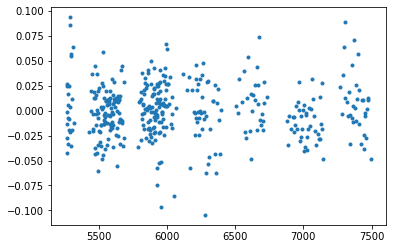

In [4]:
try:
    t, resy, resyerr = fitter.get_residual()
except ValueError:
    t, resy = fitter.get_residual()

plt.plot(t,resy,'.')
plt.show()

#### Print results

In [5]:
print('freq = ', pfit[0], perr[0])

ncomponents = int((len(pfit)-1)/2)
for i in range(1, ncomponents + 1 ):
    print('A%d   = ' % i,   pfit[i],             perr[i])
    print('Phi%d = ' % i,   pfit[i+ncomponents], perr[i+ncomponents])
    
print('Zero point =', pfit[-1], perr[-1])

freq =  3.2592376561513055 2.917468954159881e-06
A1   =  0.16370665534685636 0.001934394865340876
Phi1 =  5.265728999001157 0.0018806108038691516
A2   =  0.04516763452307171 0.001934394865340876
Phi2 =  1.0248922555458728 0.006816130797226538
A3   =  0.011324123446583062 0.001934394865340876
Phi3 =  2.559799617810818 0.02718696119508286
A4   =  0.008730056419755636 0.001934394865340876
Phi4 =  4.9799472392713815 0.035265351093710255
Zero point = 17.767880661083378 0.050574938885383475


#### Calculate Fourier parameters

In [6]:
freq,period,P21,P31,R21,R31 = fitter.get_fourier_parameters()

print('freq = ',  freq.n,   freq.s)
print('period = ',period.n, period.s)
print('R21 = ',   R21.n,    R21.s)
print('R31 = ',   R31.n,    R31.s)
print('P21 = ',   P21.n,    P21.s)
print('P31 = ',   P31.n,    P31.s)

freq =  3.2592376561513055 2.917468954159881e-06
period =  0.3068202154920047 2.7464657310801914e-07
R21 =  0.275905914926745 0.012257727676791234
R31 =  0.06917326252002325 0.011844462402624585
P21 =  3.059804871902731 0.00778501297541742
P31 =  5.612168542346106 0.027766186846299324
